In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load attributions and input data
print("Loading attributions and input data...")
attributions = np.load('../results/attributions/attributions.npy')
input_data = np.load('../data/processed/X.npy', allow_pickle=True)  # Ensure the correct file path
print(f"Attributions shape: {attributions.shape}")
print(f"Input data shape: {input_data.shape}")

# One-hot encode input data if necessary
def one_hot_encode(sequence, max_len):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'a': 0, 'c': 1, 'g': 2, 't': 3}
    one_hot = np.zeros((max_len, 4), dtype=np.int8)
    for i, char in enumerate(sequence[:max_len]):
        if char in mapping:
            one_hot[i, mapping[char]] = 1
    return one_hot

# Define the maximum sequence length
max_len = 18593

# One-hot encode validation data
print("One-hot encoding input data...")
input_data_encoded = np.array([one_hot_encode(seq, max_len) for seq in input_data])
print(f"One-hot encoded input data. Shape: {input_data_encoded.shape}")

# Extract high-attribution seqlets
def extract_high_attribution_seqlets(attributions, input_data, threshold=0.5):
    seqlets = []
    for seq_idx, seq_attributions in enumerate(attributions):
        high_attr_positions = np.where(seq_attributions > threshold)[0]
        for pos in high_attr_positions:
            if pos-10 >= 0 and pos+10 < input_data.shape[1]:  # Ensure seqlet is within bounds
                seqlet = input_data[seq_idx, pos-10:pos+10, :]  # Example: 20bp seqlets
                seqlets.append(seqlet)
    return np.array(seqlets)

print("Extracting high-attribution seqlets...")
high_attribution_seqlets = extract_high_attribution_seqlets(attributions, input_data_encoded)
print(f"Total high-attribution seqlets extracted: {len(high_attribution_seqlets)}")

# Save seqlets
np.save('../results/seqlets/high_attribution_seqlets.npy', high_attribution_seqlets)
print("High-attribution seqlets saved.")

# Cluster seqlets using DBSCAN
def cluster_seqlets(seqlets, eps=0.5, min_samples=5):
    seqlet_vectors = seqlets.reshape(len(seqlets), -1)
    similarity_matrix = cosine_similarity(seqlet_vectors)
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(1 - similarity_matrix)
    return clustering.labels_

print("Clustering high-attribution seqlets...")
labels = cluster_seqlets(high_attribution_seqlets)
print(f"Clustering completed. Number of clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")

# Visualize clusters
print("Visualizing clusters...")
plt.scatter(range(len(labels)), labels, c=labels, cmap='viridis', s=5)
plt.colorbar()
plt.xlabel('Seqlet Index')
plt.ylabel('Cluster Label')
plt.title('Seqlet Clustering')
plt.show()
print("Clusters visualization completed.")

# Save clustering results
np.save('../results/clusters/seqlet_clusters.npy', labels)
print("Clustering results saved.")


Loading attributions and input data...
Attributions shape: (25, 18593, 4)
Input data shape: (57882,)
One-hot encoding input data...
One-hot encoded input data. Shape: (57882, 18593, 4)
Extracting high-attribution seqlets...
Total high-attribution seqlets extracted: 1384
High-attribution seqlets after filtering: 842
High-attribution seqlets saved.
Clustering high-attribution seqlets...
Clustering completed. Number of clusters: 3
Visualizing clusters...


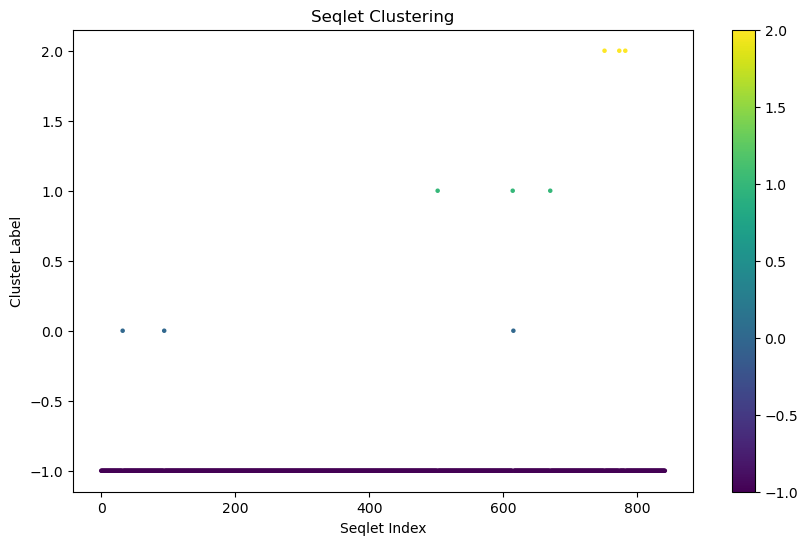

Clusters visualization completed.
Clustering results saved.


<Figure size 2000x400 with 0 Axes>

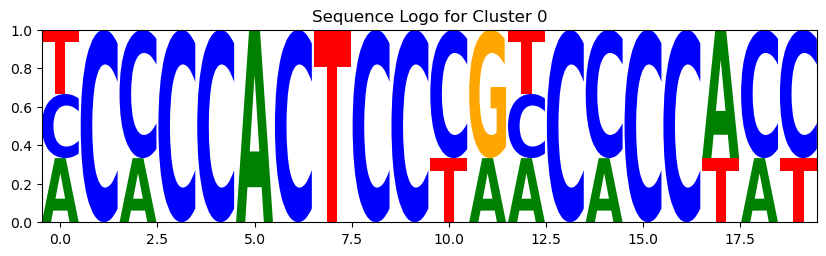

<Figure size 2000x400 with 0 Axes>

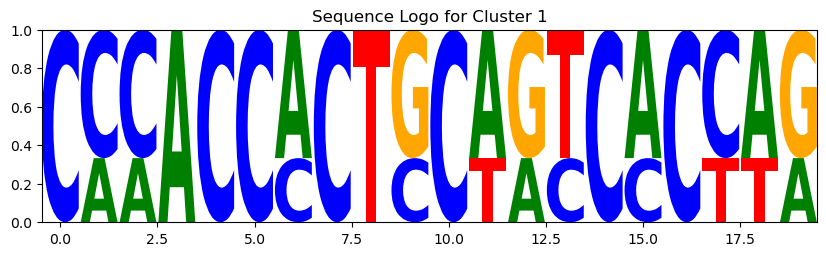

<Figure size 2000x400 with 0 Axes>

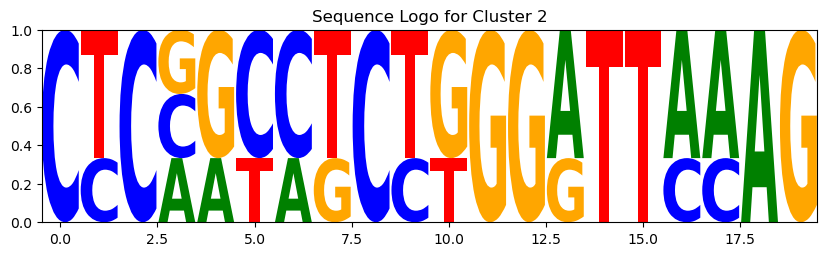

Sequence logos created and saved.


In [61]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import logomaker
import pandas as pd
import os

# Create directories to save seqlets and images if they don't exist
seqlets_dir = '../results/seqlets'
os.makedirs(seqlets_dir, exist_ok=True)
images_dir = '../results/images'
os.makedirs(images_dir, exist_ok=True)

# Load attributions and input data
print("Loading attributions and input data...")
attributions = np.load('../results/sequences/attributions_subset.npy')  # Ensure the correct file path
input_data = np.load('../data/processed/X.npy', allow_pickle=True)  # Ensure the correct file path
print(f"Attributions shape: {attributions.shape}")
print(f"Input data shape: {input_data.shape}")

# Define the one-hot encoding function
def one_hot_encode(sequence, max_len):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'a': 0, 'c': 1, 'g': 2, 't': 3}
    one_hot = np.zeros((max_len, 4), dtype=np.int8)
    for i, char in enumerate(sequence[:max_len]):
        if char in mapping:
            one_hot[i, mapping[char]] = 1
    return one_hot

# Define the maximum sequence length
max_len = 18593

# One-hot encode input data if necessary
print("One-hot encoding input data...")
input_data_encoded = np.array([one_hot_encode(seq, max_len) for seq in input_data])
print(f"One-hot encoded input data. Shape: {input_data_encoded.shape}")

# Extract high-attribution seqlets with a lower threshold
def extract_high_attribution_seqlets(attributions, input_data, threshold=0.015):  # Adjusted threshold
    seqlets = []
    for seq_idx, seq_attributions in enumerate(attributions):
        high_attr_positions = np.where(np.max(np.abs(seq_attributions), axis=1) > threshold)[0]
        for pos in high_attr_positions:
            if pos-10 >= 0 and pos+10 < input_data.shape[1]:  # Ensure seqlet is within bounds
                seqlet = input_data[seq_idx, pos-10:pos+10, :]  # Example: 20bp seqlets
                seqlets.append(seqlet)
    return np.array(seqlets)

print("Extracting high-attribution seqlets...")
high_attribution_seqlets = extract_high_attribution_seqlets(attributions, input_data_encoded)
print(f"Total high-attribution seqlets extracted: {len(high_attribution_seqlets)}")

# Filter out low-variance seqlets
def filter_low_variance_seqlets(seqlets, variance_threshold=0.001):
    variances = np.var(seqlets, axis=(1, 2))
    high_variance_seqlets = seqlets[variances > variance_threshold]
    return high_variance_seqlets

high_attribution_seqlets = filter_low_variance_seqlets(high_attribution_seqlets)
print(f"High-attribution seqlets after filtering: {len(high_attribution_seqlets)}")

# Save seqlets
np.save(os.path.join(seqlets_dir, 'high_attribution_seqlets.npy'), high_attribution_seqlets)
print("High-attribution seqlets saved.")

# Cluster seqlets using DBSCAN
def cluster_seqlets(seqlets, eps=0.3, min_samples=3):
    seqlet_vectors = seqlets.reshape(len(seqlets), -1)
    similarity_matrix = cosine_similarity(seqlet_vectors)
    distance_matrix = 1 - similarity_matrix
    distance_matrix[distance_matrix < 0] = 0  # Ensure no negative values
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(distance_matrix)
    return clustering.labels_

print("Clustering high-attribution seqlets...")
labels = cluster_seqlets(high_attribution_seqlets)
print(f"Clustering completed. Number of clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")

# Visualize clusters
print("Visualizing clusters...")
plt.figure(figsize=(10, 6))
plt.scatter(range(len(labels)), labels, c=labels, cmap='viridis', s=5)
plt.colorbar()
plt.xlabel('Seqlet Index')
plt.ylabel('Cluster Label')
plt.title('Seqlet Clustering')
plt.savefig(os.path.join(images_dir, 'seqlet_clustering.png'))
plt.show()
print("Clusters visualization completed.")

# Save clustering results
np.save('../results/clusters/seqlet_clusters.npy', labels)
print("Clustering results saved.")

#Create and visualize sequence logos for each cluster
unique_labels = set(labels)
for cluster in unique_labels:
    if cluster != -1:  # Ignore noise points labeled as -1
        cluster_seqlets = high_attribution_seqlets[labels == cluster]
        avg_attributions = np.mean(cluster_seqlets, axis=0)
        
        # Create sequence logo
        plot_length = min(400, avg_attributions.shape[0])  # Adjust the plot length as needed
        logo_df = pd.DataFrame(avg_attributions[:plot_length], columns=['A', 'C', 'G', 'T'])
        
        # Plot sequence logo
        plt.figure(figsize=(20, 4))
        logomaker.Logo(logo_df, color_scheme='classic')
        plt.title(f'Sequence Logo for Cluster {cluster}')
        plt.savefig(os.path.join(images_dir, f'sequence_logo_cluster_{cluster}.png'))
        plt.show()

print("Sequence logos created and saved.")


In [35]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Assuming high_attribution_seqlets is already defined and loaded

# Define the clustering function
def cluster_seqlets(seqlets, eps=0.5, min_samples=5):
    seqlet_vectors = seqlets.reshape(len(seqlets), -1)
    similarity_matrix = cosine_similarity(seqlet_vectors)
    distance_matrix = 1 - similarity_matrix
    distance_matrix[distance_matrix < 0] = 0  # Ensure no negative values
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(distance_matrix)
    return clustering.labels_

# Define a function to filter seqlets based on variance
def filter_low_variance_seqlets(seqlets, variance_threshold):
    variances = np.var(seqlets, axis=(1, 2))
    high_variance_seqlets = seqlets[variances > variance_threshold]
    return high_variance_seqlets

# Initial variance threshold
variance_threshold = 0.01

# Increment step
increment_step = 0.01

# Start with the initial threshold and incrementally increase it
for i in range(10):  # Example: Increment 10 times
    high_attribution_seqlets_filtered = filter_low_variance_seqlets(high_attribution_seqlets, variance_threshold)
    print(f"Threshold: {variance_threshold}, Remaining seqlets: {len(high_attribution_seqlets_filtered)}")
    
    # Perform clustering with the filtered seqlets
    labels = cluster_seqlets(high_attribution_seqlets_filtered)
    print(f"Clustering with threshold {variance_threshold}. Number of clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")
    
    # Increment the variance threshold
    # Extract high-attribution seqlets
def extract_high_attribution_seqlets(attributions, input_data, threshold=0.01):  # Lower the threshold further
    seqlets = []
    for seq_idx, seq_attributions in enumerate(attributions):
        high_attr_positions = np.where(np.max(seq_attributions, axis=1) > threshold)[0]
        for pos in high_attr_positions:
            seq_length = len(input_data[seq_idx])  # Get the actual length of the sequence
            if pos-10 >= 0 and pos+10 < seq_length:  # Ensure seqlet is within bounds
                seqlet = input_data[seq_idx][pos-10:pos+10]  # Example: 20bp seqlets
                seqlet_one_hot = one_hot_encode(seqlet)  # One-hot encode the seqlet
                seqlets.append(seqlet_one_hot)
    return np.array(seqlets)

print("Extracting high-attribution seqlets...")
high_attribution_seqlets = extract_high_attribution_seqlets(attributions, input_data)
print(f"Total high-attribution seqlets extracted: {len(high_attribution_seqlets)}")

if len(high_attribution_seqlets) == 0:
    print("No high-attribution seqlets found. Adjust the threshold or check the attributions.")
else:
    # Visualize a few sample seqlets
    for i in range(min(5, len(high_attribution_seqlets))):
        print(f"Seqlet {i+1}:")
        print(high_attribution_seqlets[i])
        print("
")

    # Normalize seqlets for better clustering
    def normalize_seqlets(seqlets):
        seqlets = seqlets.astype(np.float32)
        seqlets /= np.max(np.abs(seqlets), axis=1, keepdims=True) + 1e-10
        return seqlets

    high_attribution_seqlets = normalize_seqlets(high_attribution_seqlets)

    # Save seqlets
    np.save('../results/seqlets/high_attribution_seqlets_subset.npy', high_attribution_seqlets)
    print("High-attribution seqlets saved.")

    # Cluster seqlets using DBSCAN with different parameters
    def cluster_seqlets(seqlets, eps=0.1, min_samples=10):
        seqlet_vectors = seqlets.reshape(len(seqlets), -1)
        similarity_matrix = cosine_similarity(seqlet_vectors)
        similarity_matrix = (similarity_matrix + 1) / 2  # Scale cosine similarity to [0, 1]
        clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(1 - similarity_matrix)
        return clustering.labels_

    print("Clustering high-attribution seqlets...")
    labels = cluster_seqlets(high_attribution_seqlets)
    print(f"Clustering completed. Number of clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")

    # Visualize clusters
    print("Visualizing clusters...")
    plt.scatter(range(len(labels)), labels, c=labels, cmap='viridis', s=5)
    plt.colorbar()
    plt.xlabel('Seqlet Index')
    plt.ylabel('Cluster Label')
    plt.title('Seqlet Clustering')
    plt.show()
    print("Clusters visualization completed.")

    # Save clustering results
    np.save('../results/clusters/seqlet_clusters_subset.npy', labels)
    print("Clustering results saved.")


Threshold: 0.01, Remaining seqlets: 0


ValueError: cannot reshape array of size 0 into shape (0,newaxis)